In [72]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from  torchvision import transforms
from torchvision.datasets import CIFAR10

from pl_bolts.models.autoencoders.components import resnet18_encoder, resnet18_decoder

import matplotlib.pyplot as plt

/clusterstorage/gkobsik/anaconda3/envs/dive_into_deep_learning/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/clusterstorage/gkobsik/anaconda3/envs/dive_into_deep_learning/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/clusterstorage/gkobsik/anaconda3/envs/dive_into_deep_learning/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_s

### Load Data

Files already downloaded and verified
Files already downloaded and verified


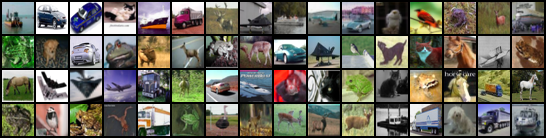

In [73]:
# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.ColorJitter(brightness=.1, hue=.1)])
train_set = CIFAR10(root=".././data", train=True, download=True, transform=transform)
test_set = CIFAR10(root=".././data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=256, drop_last=True, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0][:64], nrow=16)
transforms.ToPILImage()(grid_img)

### Define Model

In [92]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        std = torch.rand(1, device=tensor.device) * self.std
        return tensor + torch.randn(tensor.size(), device=tensor.device) * std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class Autoencoder(L.LightningModule):
    def __init__(self, latent_dim=128, gaussian_noise=0.0):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            resnet18_encoder(
                first_conv=False, 
                maxpool1=False,
            ),  # 3x32x32 -> 512
            nn.Linear(512, latent_dim),  # 512 -> latent_dim
        )
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=32,
            first_conv=False,
            maxpool1=False,
        ) # latent_dim -> 3x32x32

        self.noise = AddGaussianNoise(mean=0, std=gaussian_noise)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.noise(x)
        y = self.forward(x_hat)
        loss = F.mse_loss(y, x, reduction="none") + F.l1_loss(y, x, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss, prog_bar=True)

### Run Training

In [93]:
LATENT_DIM = 128
NUM_EPOCHS = 10
GAUSSIAN_NOISE = 0.0

trainer = L.Trainer(
    enable_checkpointing=False,
    logger=False,
    accelerator="auto",
    devices=1,
    max_epochs=NUM_EPOCHS,
)

model=Autoencoder(latent_dim=LATENT_DIM, gaussian_noise=GAUSSIAN_NOISE)
trainer.fit(model, train_loader)

/clusterstorage/gkobsik/anaconda3/envs/dive_into_deep_learning/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /clusterstorage/gkobsik/anaconda3/envs/dive_into_dee ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/tmp/ipykernel_244407/450464139.py:19: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  resnet18_encoder(
/clusterstorage/gkobsik/anaconda3/envs/dive_into_deep_learning/lib/python3.10

Epoch 9: 100%|██████████| 195/195 [00:54<00:00,  3.61it/s, train_loss=248.0] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 195/195 [00:54<00:00,  3.61it/s, train_loss=248.0]


In [94]:
test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
print("Test Loss:", test_result[0]['test_loss'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:03<00:00, 11.86it/s]
Test Loss: 267.4240417480469


### Reconstruction (Autoencoding)

In [95]:
NUM_SAMPLES = 8

In [96]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True)
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

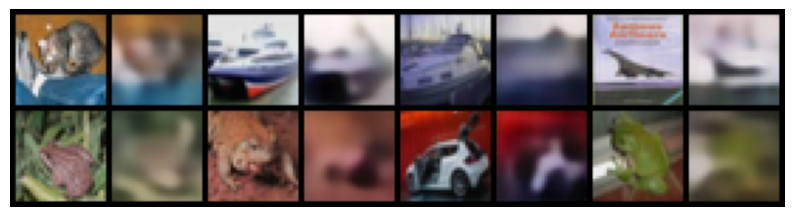

In [97]:
# 0% noise
input_imgs = next(iter(test_loader))[0][:NUM_SAMPLES]
visualize_reconstructions(model, input_imgs)

### Denoising

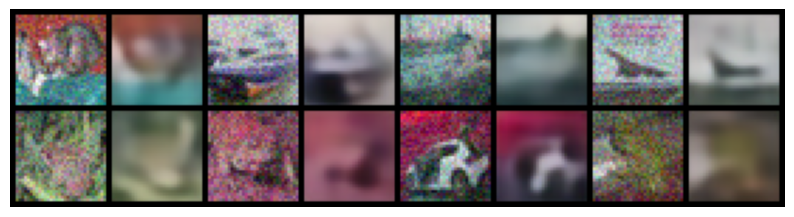

In [98]:
# 25% noise
input_imgs = 0.75 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.25 * torch.rand(NUM_SAMPLES, 3, 32, 32)
visualize_reconstructions(model, input_imgs)

### Generation (Sampling from Latent Space)

In [99]:
def generate_new_images(model, latent_vectors):
    model.eval()
    latent_vectors.to(device=model.device)
    with torch.no_grad():
        imgs = model.decoder(latent_vectors)
        imgs = imgs.cpu()

    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, pad_value=0.5)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

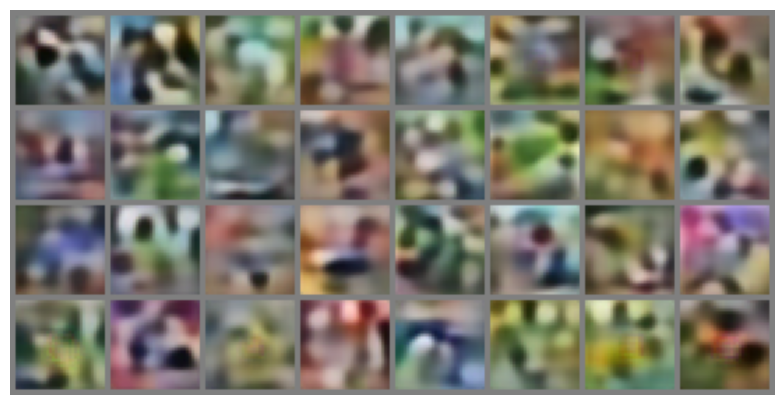

In [103]:
random_vectors = torch.randn(4 * NUM_SAMPLES, LATENT_DIM)
generate_new_images(model, random_vectors)